In [285]:
### Check out correlations between ligand, receptors and targets and combine with nichenet data

#############################################
# Prerequisites - Load Libraries

In [286]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"


In [287]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [288]:
data_path = '../data/current'

In [289]:
result_path = '../results/current'

In [290]:
data_path

[1] "../data/current"

In [291]:
### Version of the pre-processed data to load

In [292]:
name = 'V_FINAL'  
# of dataset to load, prepared and combined data of E1 - skip E2 step 

In [293]:
filter_samples = 'all'  # decide whether to select only a subset of samples; 'all'  = not filtering
#filter_samples = 'acs_w_o_infection_ccs'
#filter_samples = 'no_ccs_ccs'

# Load Data 

## Sample Data

In [294]:
## sample meta and clinical data

In [295]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

## Prepared combined data

In [296]:
### Select and load pre-processed and combined data

In [297]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
print(path)
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "../results/current/E-Analysis/Combined_Data_V_FINAL.csv"
[1] "2024-01-03 14:22:52 CET"


In [298]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [299]:
nrow(data_long)

[1] 1557939

In [300]:
length(unique(data_long$variable))

[1] 13289

## Ligand Receptor Data

In [301]:
## Load ligand receptor interactions from nichenet 

In [302]:
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds")) # ligand receptor interactions

In [303]:
head(lr_network,2)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg


In [304]:
## Summarise to have only ligand or receptor assignment not double

In [305]:
ligand_receptor_interactions = lr_network %>% group_by(from,to) %>% count()

In [306]:
colnames(ligand_receptor_interactions) = c('Ligand', 'Receptor', 'amount_sources')

In [307]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [308]:
### Aggregate to contain only unique ligand-receptor interactions across different data sources

In [309]:
ligand_amounts = ligand_receptor_interactions %>% group_by(Ligand) %>% summarise(amount_l = sum(amount_sources))

In [310]:
receptor_amounts = ligand_receptor_interactions %>% group_by(Receptor) %>% summarise(amount_r = sum(amount_sources))

In [311]:
l_r_merged = merge(ligand_amounts, receptor_amounts, by.x = 'Ligand', by.y = 'Receptor')

In [312]:
ligand = l_r_merged$Ligand[l_r_merged$amount_l >= l_r_merged$amount_r]

In [313]:
receptor = l_r_merged$Ligand[l_r_merged$amount_l < l_r_merged$amount_r]

In [314]:
nrow(l_r_merged)

[1] 115

In [315]:
head(l_r_merged,2)

,Ligand,amount_l,amount_r
,<chr>,<int>,<int>
1,ALCAM,3,2
2,AMIGO1,2,1


In [316]:
length(ligand)  # amount ligands

[1] 84

In [317]:
length(receptor)  # amount receptors

[1] 31

In [318]:
### Filter out and decide whether it is a receptor or ligand

In [319]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [320]:
ligand_receptor_interactions = ligand_receptor_interactions[!ligand_receptor_interactions$Receptor %in% ligand,]

In [321]:
ligand_receptor_interactions = ligand_receptor_interactions[!ligand_receptor_interactions$Ligand %in% receptor,]

In [322]:
nrow(ligand_receptor_interactions)

[1] 11639

In [323]:
## Generate a dataset specifying ligand and receptor genes

In [324]:
ligand_receptor_vars = rbind(data.frame(gene = ligand_receptor_interactions$Ligand, interaction_type = 'Ligand'), data.frame(gene = ligand_receptor_interactions$Receptor, interaction_type = 'Receptor'))

In [325]:
ligand_receptor_vars = unique(ligand_receptor_vars)

In [326]:
head(ligand_receptor_vars,2)

,gene,interaction_type
,<chr>,<chr>
1,A2M,Ligand
4,AANAT,Ligand


In [327]:
nrow(ligand_receptor_vars)

[1] 1414

In [328]:
# remove empty spaces
ligand_receptor_vars$gene = str_replace(ligand_receptor_vars$gene, ' ', '')

## Available ligand receptor potential + transcription factor datasets from  nichenet

In [329]:
## Weighted networks

In [330]:
weighted_networks = readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds")) # integrated weighted ligand-signaling and gene regulatory network

In [331]:
## Prepared influential matrices

In [332]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [333]:
### Generate data in long format

In [334]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [335]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [336]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [337]:
length(unique(ligand_target_matrix_long$ligand))

[1] 688

## Cell Gene Expression Data (percentage of cells expressing gene)

In [338]:
## Load information about how many cells express a gene generated in C0 Script

In [339]:
path = paste0(result_path, '/C-Analysis/C0_Filter_Genes_Input_Correlations_Perc_Values.csv')
cell_perc_cluster = read.csv( path) # cluster alternative
print(file.info(path)$mtime)

[1] "2024-01-03 14:10:30 CET"


In [340]:
### Filter on relevant cell types (clusters with low amount of cells per sample; similar to MOFA analysis)

In [341]:
cell_perc_cluster = cell_perc_cluster[!(cell_perc_cluster$cluster %in% c('16_Plasma Blast', '14_Other', '17_Progenitor', '15_Plasma Blast', '18_Megakaryocytes' ,'Plasma Blast', 'Other', 'Progenitor', 'Plasma Blast', 'Megakaryocytes' )),]

In [342]:
unique(cell_perc_cluster$cluster)

[1] "8_B-cell"                   "9_Monocytes - CD16_FCGR3A" 
 [3] "5_T-cell-CD4"               "0_T-cell-CD4"              
 [5] "1_T-cell-CD8"               "6_Monocytes - CD14"        
 [7] "2_T-cell-CD4"               "4_Monocytes - CD14"        
 [9] "11_T-cell-CD4"              "3_NK"                      
[11] "7_Monocytes - CD14"         "13_Dendritic"              
[13] "10_B-cell"                  "12_Monocytes - CD16_FCGR3A"

In [343]:
head(cell_perc_cluster,2)

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,8_B-cell
2,AL627309.4,0.05406136,4,AL627309.4,8_B-cell


# Data Preparations

## Prepare list of cytokines in data

In [344]:
## determine all cytokines in input data

In [345]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [346]:
cytokines = unique(data_long$variable[data_long$type == 'cytokine'])

In [347]:
head(cytokines)

[1] "BCA1__CXCL13"    "CTACK__CCL27"    "EGF__EGF"        "ENA78__CXCL5"   
[5] "Eotaxin__CCL11"  "Eotaxin2__CCL24"

In [348]:
cytokines = str_replace(cytokines, '.*__', '') # extract gene code from cytokines

In [349]:
head(cytokines)

[1] "CXCL13" "CCL27"  "EGF"    "CXCL5"  "CCL11"  "CCL24"

In [350]:
nrow(ligand_receptor_interactions[ligand_receptor_interactions$Ligand %in% cytokines,])  # check how many ligand receptor interactions contain cytokine ligand

[1] 1236

## Adjustments on input data

### Filter samples (optional)

In [351]:
## filter out some samples if specified in the beginning

In [352]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [353]:
unique(sample_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [354]:
if(filter_samples == 'all'){
    filter = unique(sample_data$sample_id)
    }


if(filter_samples == 'acs_w_o_infection_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('ccs', 'acs_w_o_infection')])
    
    }

if(filter_samples == 'no_ccs_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('vollstaendiger_ausschluss','ccs','koronarsklerose')])
    
    }

In [355]:
length(filter)

[1] 146

In [356]:
#filter

In [357]:
nrow(data_long)

[1] 1557939

In [358]:
data_long = data_long[data_long$sample_id %in% filter,]

In [359]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [360]:
nrow(data_long)

[1] 1557939

### Filter on expression

In [361]:
## Filter out features with low expression (as in E2 script)

In [362]:
data_long$expression = TRUE

In [363]:
data_long$expression[data_long$value == 0] = FALSE

In [364]:
expression_filter = data_long %>% group_by(type, variable) %>% summarise(perc_expression = sum(expression)  )

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


In [365]:
expression_filter$perc_expression = expression_filter$perc_expression / length(unique(data_long$sample_id))

In [366]:
filtered_out = expression_filter[expression_filter$perc_expression <= 0.2,]  # threshold: minimum expression in 20% of samples

In [367]:
expression_filter = expression_filter[expression_filter$perc_expression > 0.2,]

In [368]:
nrow(expression_filter)

[1] 13283

In [369]:
filtered_out   # features that are filtered out because of too low expression

type,variable,perc_expression
<chr>,<chr>,<dbl>
cytokine,IL16__IL16,0.0890411
cytokine,IL21__IL21,0.1575342
cytokine,IL23__IL23,0.1506849
cytokine,IL28A__IL28,0.1027397
cytokine,IL33__IL33,0.1643836
cytokine,TSLP__TSLP,0.1780822


In [370]:
# filter the data
data_long = merge(data_long, expression_filter[,c('type', 'variable')], by.x = c('type', 'variable'), by.y = c('type', 'variable'))   

In [371]:
unique(data_long$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [372]:
nrow(data_long)

[1] 1557183

In [374]:
data_long$ident = paste0(data_long$type, '_0_', data_long$variable)

### Extract gene format

In [381]:
## Extract gene codes from variables

In [382]:
data_long$gene = str_replace(data_long$variable, '.*__', '')

In [383]:
data_long$gene[data_long$type == 'proteomics'] = str_replace(data_long$gene[data_long$type == 'proteomics'], '_.*', '')

### Data filtered for ligands and receptors

In [398]:
### Filter dataset on ligand and receptor variables

In [399]:
data_long_lig_rec = merge(data_long, ligand_receptor_vars)

In [400]:
# overview amount of ligands and receptors measured per dimension 
unique(data_long_lig_rec[,c('type', 'interaction_type', 'gene')]) %>% group_by(type, interaction_type) %>% count()

type,interaction_type,n
<chr>,<chr>,<int>
cytokine,Ligand,61
neutrophil,Ligand,24
neutrophil,Receptor,43
proteomics,Ligand,53
proteomics,Receptor,19
single_cell,Ligand,53
single_cell,Receptor,75


In [401]:
## generate a variable defining type: cell-type cluster or view

In [402]:
data_long_lig_rec$cluster = data_long_lig_rec$type

In [403]:
data_long_lig_rec$cluster[data_long_lig_rec$type == 'single_cell'] = str_replace(data_long_lig_rec$variable[data_long_lig_rec$type == 'single_cell'] , '__.*', '')

In [404]:
unique(data_long_lig_rec$cluster)

[1] "proteomics"                  "neutrophil"                 
 [3] "X6_Monocytes...CD14"         "X4_Monocytes...CD14"        
 [5] "X7_Monocytes...CD14"         "X3_NK"                      
 [7] "X10_B.cell"                  "X0_T.cell.CD4"              
 [9] "X13_Dendritic"               "X1_T.cell.CD8"              
[11] "X11_T.cell.CD4"              "X5_T.cell.CD4"              
[13] "X12_Monocytes...CD16_FCGR3A" "X2_T.cell.CD4"              
[15] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[17] "cytokine"

In [405]:
unique(data_long_lig_rec$type)

[1] "proteomics"  "neutrophil"  "single_cell" "cytokine"

In [406]:
head(data_long_lig_rec,2)

,gene,type,variable,X,sample_id,value,config,expression,ident,interaction_type,cluster
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>
1,A2M,proteomics,A2M_P01023,1439494,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,proteomics
2,A2M,proteomics,A2M_P01023,1439557,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,proteomics


#### Add information about percentage of cells expressing gene

In [407]:
## add to the ligand receptor dataset

In [408]:
data_long_lig_rec$X = NULL

In [409]:
cell_perc_cluster$cluster = make.names(cell_perc_cluster$cluster)

In [410]:
nrow(data_long_lig_rec)

[1] 95246

In [411]:
head(cell_perc_cluster,2)

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,X8_B.cell
2,AL627309.4,0.05406136,4,AL627309.4,X8_B.cell


In [412]:
head(data_long_lig_rec,2)

,gene,type,variable,sample_id,value,config,expression,ident,interaction_type,cluster
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>
1,A2M,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,proteomics
2,A2M,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,proteomics


In [413]:
unique(data_long_lig_rec$cluster)  # check to have same cluster names in both

[1] "proteomics"                  "neutrophil"                 
 [3] "X6_Monocytes...CD14"         "X4_Monocytes...CD14"        
 [5] "X7_Monocytes...CD14"         "X3_NK"                      
 [7] "X10_B.cell"                  "X0_T.cell.CD4"              
 [9] "X13_Dendritic"               "X1_T.cell.CD8"              
[11] "X11_T.cell.CD4"              "X5_T.cell.CD4"              
[13] "X12_Monocytes...CD16_FCGR3A" "X2_T.cell.CD4"              
[15] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[17] "cytokine"

In [414]:
unique(cell_perc_cluster$cluster)

[1] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A" 
 [3] "X5_T.cell.CD4"               "X0_T.cell.CD4"              
 [5] "X1_T.cell.CD8"               "X6_Monocytes...CD14"        
 [7] "X2_T.cell.CD4"               "X4_Monocytes...CD14"        
 [9] "X11_T.cell.CD4"              "X3_NK"                      
[11] "X7_Monocytes...CD14"         "X13_Dendritic"              
[13] "X10_B.cell"                  "X12_Monocytes...CD16_FCGR3A"

In [415]:
## merge the data
data_long_lig_rec = merge(data_long_lig_rec, cell_perc_cluster, all.x = TRUE) # also keep cytokine, proteomics dimension where no cell expression is available

In [416]:
head(data_long_lig_rec,2)

,gene,cluster,type,variable,sample_id,value,config,expression,ident,interaction_type,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<int>
1,A2M,proteomics,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,NA,NA,NA
2,A2M,proteomics,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,NA,NA,NA


In [417]:
# Set dummy mean expression for proteomic/ cytokine data etc. where no mean cell expression values are available
data_long_lig_rec$perc_cells_expressing_gene[is.na(data_long_lig_rec$perc_cells_expressing_gene)] = mean(data_long_lig_rec$perc_cells_expressing_gene, na.rm = TRUE)

In [418]:
unique(data_long_lig_rec$type)

[1] "proteomics"  "neutrophil"  "single_cell" "cytokine"

#### Aggregate expression across samples (mean expression etc.)

In [419]:
## for ligand- receptor data

In [420]:
### Calculate variance and mean expression per cell-type across samples for single cell data

analyze_expr_cluster = data_long_lig_rec %>% group_by(type, interaction_type, gene, cluster, perc_cells_expressing_gene, total_amount_cells_expressing_gene, ident) %>% 
summarise(#mean_expr_norm = mean(value_norm, na.rm = TRUE),
          mean_expr = mean(value, na.rm = TRUE), 
          var_expression = var(value, na.rm = TRUE))

`summarise()` has grouped output by 'type', 'interaction_type', 'gene',
'cluster', 'perc_cells_expressing_gene', 'total_amount_cells_expressing_gene'.
You can override using the `.groups` argument.


In [421]:
### Generate cell type columns
analyze_expr_cluster$cell_type = str_replace(analyze_expr_cluster$cluster, 'X.*_', '')

In [422]:
head(analyze_expr_cluster,2)

type,interaction_type,gene,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr,var_expression,cell_type
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>
cytokine,Ligand,CCL1,cytokine,69.10381,NA,cytokine_0_I309__CCL1,1.457331,0.4209982,cytokine
cytokine,Ligand,CCL11,cytokine,69.10381,NA,cytokine_0_Eotaxin__CCL11,7.408225,3.1654144,cytokine


In [423]:
unique(analyze_expr_cluster$cell_type)

[1] "cytokine"         "neutrophil"       "proteomics"       "Monocytes...CD14"
 [5] "T.cell.CD4"       "B.cell"           "FCGR3A"           "Dendritic"       
 [9] "T.cell.CD8"       "NK"

#### Cluster similar receptors and ligand (expressed in same cell-types)

In [424]:
### Cluster Receptors

In [425]:
filter_type_vis = c('cytokine', 'proteomics', 'neutrophil')  # only for sc data exclude other types

In [426]:
cluster_data = analyze_expr_cluster[(analyze_expr_cluster$interaction_type == 'Receptor') & (!analyze_expr_cluster$type %in% filter_type_vis),] %>% dcast(gene ~ cluster, value.var = 'mean_expr')
# value_var = mean_expression

In [427]:
cluster_data[is.na(cluster_data)] = 0

In [428]:
rownames(cluster_data) = cluster_data$gene

In [429]:
cluster_data$gene = NULL

In [430]:
head(cluster_data,2)

,X0_T.cell.CD4,X1_T.cell.CD8,X10_B.cell,X11_T.cell.CD4,X12_Monocytes...CD16_FCGR3A,X13_Dendritic,X2_T.cell.CD4,X3_NK,X4_Monocytes...CD14,X5_T.cell.CD4,X6_Monocytes...CD14,X7_Monocytes...CD14,X8_B.cell,X9_Monocytes...CD16_FCGR3A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AGTRAP,0,0,0,0,0,0,0,0,1.2045378,0,1.158767,1.183921,0,0
ANXA6,0,0,0,0,0,0,0,0,0.7138537,0,0.000000,0.000000,0,0


In [431]:
# cluster the receptors based on mean expression
cluster_result = kmeans(cluster_data, centers = 7, iter.max = 10, nstart = 1)

In [432]:
cluster_result = data.frame(cluster= cluster_result$cluster, gene = names(cluster_result$cluster))

In [433]:
cluster_result$interaction_type = 'Receptor'

In [434]:
head(cluster_result,2)

,cluster,gene,interaction_type
,<int>,<chr>,<chr>
AGTRAP,7,AGTRAP,Receptor
ANXA6,7,ANXA6,Receptor


In [435]:
### Cluster Ligands

In [436]:
# Filter to only do for sc data
cluster_data = analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Ligand' & (!analyze_expr_cluster$type %in% filter_type_vis),] %>% dcast(gene ~ cluster, value.var = 'mean_expr')

In [437]:
cluster_data[is.na(cluster_data)] = 0

In [438]:
rownames(cluster_data) = cluster_data$gene

In [439]:
cluster_data$gene = NULL

In [440]:
head(cluster_data,2)

,X0_T.cell.CD4,X1_T.cell.CD8,X10_B.cell,X11_T.cell.CD4,X12_Monocytes...CD16_FCGR3A,X13_Dendritic,X2_T.cell.CD4,X3_NK,X4_Monocytes...CD14,X5_T.cell.CD4,X6_Monocytes...CD14,X7_Monocytes...CD14,X8_B.cell,X9_Monocytes...CD16_FCGR3A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADAM17,0,0,0,0,0,0,0,0,0.8383966,0,0.8149382,0,0,0
AIMP1,0,0,0,0,0,0,0,0,0.7533036,0,0.0000000,0,0,0


In [441]:
# cluster the data
cluster_result_l = kmeans(cluster_data, centers = 10, iter.max = 10, nstart = 1)

In [442]:
cluster_result_l = data.frame(cluster= cluster_result_l$cluster, gene = names(cluster_result_l$cluster))

In [443]:
cluster_result_l$interaction_type = 'Ligand'

In [444]:
head(cluster_result_l,2)

,cluster,gene,interaction_type
,<int>,<chr>,<chr>
ADAM17,3,ADAM17,Ligand
AIMP1,3,AIMP1,Ligand


In [445]:
### Merge both cluster results

In [446]:
cluster_result = rbind(cluster_result, cluster_result_l)

In [447]:
colnames(cluster_result) = c('cluster_vis', 'gene', 'interaction_type')

In [448]:
#### Add clustering result to mean expression values and save the data 

In [449]:
analyze_expr_cluster = merge(analyze_expr_cluster, cluster_result, all.x = TRUE)

In [450]:
head(analyze_expr_cluster,2)

,interaction_type,gene,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr,var_expression,cell_type,cluster_vis
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>
1,Ligand,A2M,proteomics,proteomics,69.10381,NA,proteomics_0_A2M_P01023,8.7445302,0.32468578,proteomics,NA
2,Ligand,ADAM17,single_cell,X4_Monocytes...CD14,49.68889,7267,single_cell_0_X4_Monocytes...CD14__ADAM17,0.8383966,0.03136488,Monocytes...CD14,3


In [451]:
write.table(analyze_expr_cluster,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data_Expression', name, filter_samples,  '.gz')))

# Ligand Receptor Data

## Calculate ligand receptor correlations

In [452]:
head(data_long_lig_rec,2)

,gene,cluster,type,variable,sample_id,value,config,expression,ident,interaction_type,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<int>
1,A2M,proteomics,proteomics,A2M_P01023,k27,9.138038,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,NA,69.10381,NA
2,A2M,proteomics,proteomics,A2M_P01023,k21,9.022400,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,proteomics_0_A2M_P01023,Ligand,NA,69.10381,NA


In [453]:
### Transform to wide format

In [454]:
ligand_receptor_expression = data_long_lig_rec %>% dcast(sample_id ~ ident, value.var = 'value')

In [455]:
rownames(ligand_receptor_expression) = ligand_receptor_expression$sample_id

In [456]:
ligand_receptor_expression$sample_id = NULL

In [457]:
head(ligand_receptor_expression,2)

,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,cytokine_0_Eotaxin2__CCL24,cytokine_0_Eotaxin3__CCL26,cytokine_0_FGF2__FGF2,cytokine_0_FLT3L__FLT3LG,cytokine_0_Fractalkine__CX3CL1,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__RTN4,single_cell_0_X9_Monocytes...CD16_FCGR3A__SELPLG,single_cell_0_X9_Monocytes...CD16_FCGR3A__SERPINA1,single_cell_0_X9_Monocytes...CD16_FCGR3A__SPN,single_cell_0_X9_Monocytes...CD16_FCGR3A__TGFB1,single_cell_0_X9_Monocytes...CD16_FCGR3A__TIMP1,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFRSF14,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFRSF1B,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF10,single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF13B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k1,5.696550,9.821662,5.045268,10.562366,7.42341,8.755388,8.820594,6.734845,5.200065,7.552054,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,4.697663,9.701220,1.922198,7.724173,9.19842,9.728363,5.598127,5.791293,3.737687,5.874305,⋯,1.343136,0.6540153,2.677473,1.21784,0.8279207,2.885468,0.8118693,2.711,1.428577,1.190677


In [458]:
### Define Ligands and Receptors

In [459]:
ligands = unique(data_long_lig_rec$ident[data_long_lig_rec$interaction_type == 'Ligand'])

In [460]:
length(ligands)

[1] 445

In [461]:
receptors = unique(data_long_lig_rec$ident[data_long_lig_rec$interaction_type == 'Receptor'])

In [462]:
length(receptors)

[1] 367

In [463]:
ncol(ligand_receptor_expression)

[1] 812

In [464]:
#### Calculate correlations between ligands and receptors

In [465]:
ligand_receptor_correlations = cor(ligand_receptor_expression[,colnames(ligand_receptor_expression) %in%ligands], ligand_receptor_expression[,colnames(ligand_receptor_expression) %in% receptors], method = 'spearman', use = 'pairwise.complete.obs')
# currently calculated with spearman!

In [466]:
#### Adjust format of calculated correlations

In [467]:
ligand_receptor_correlations = melt(ligand_receptor_correlations)

In [468]:
colnames(ligand_receptor_correlations) = c('ligand', 'receptor', 'correlation')

In [469]:
head(ligand_receptor_correlations,2)

,ligand,receptor,correlation
,<fct>,<fct>,<dbl>
1,cytokine_0_BCA1__CXCL13,neutrophil_0_ABCA7,0.09543501
2,cytokine_0_CTACK__CCL27,neutrophil_0_ABCA7,0.05916357


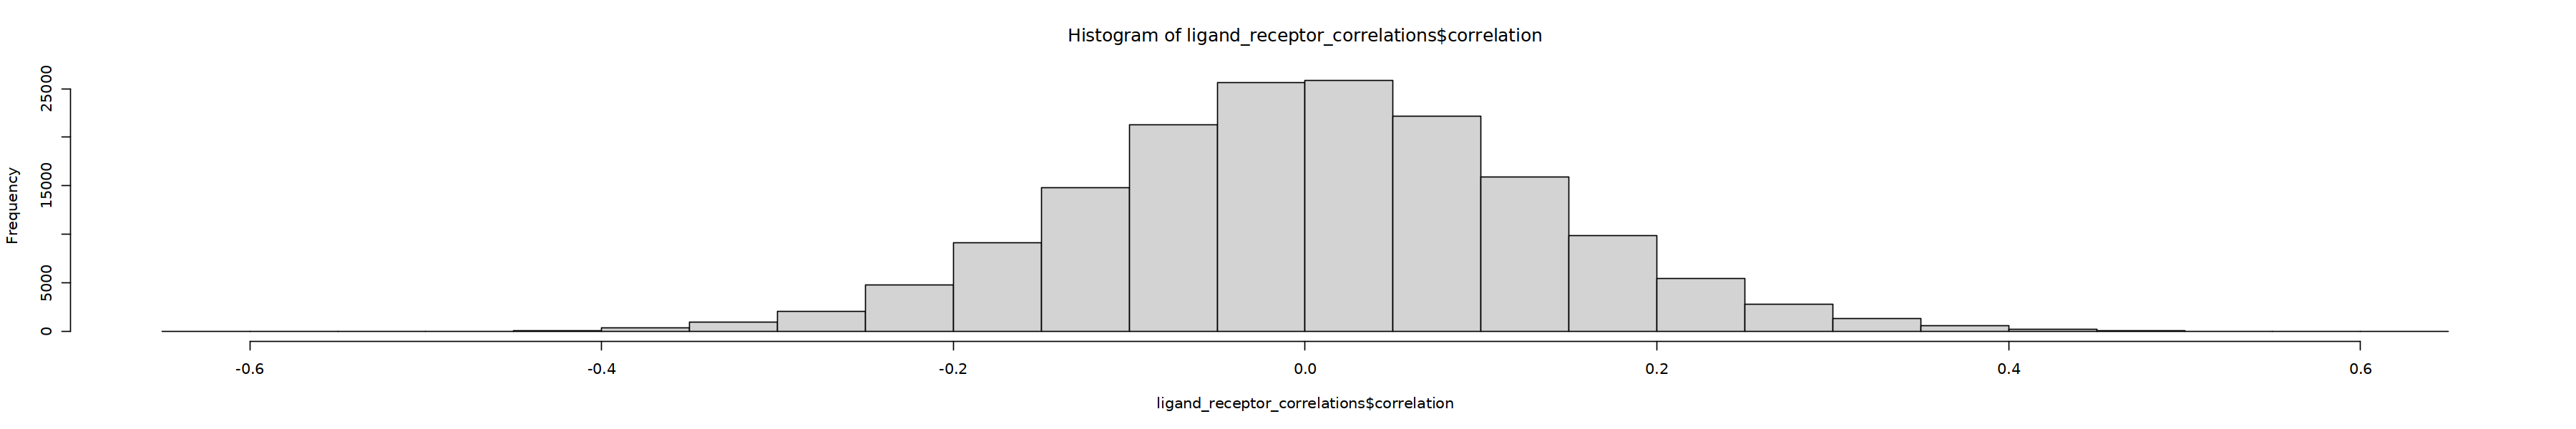

In [470]:
### Distribution of calculated correlations
options(repr.plot.width=30, repr.plot.height=5)
hist(ligand_receptor_correlations$correlation)

## Combine nichenet interaction potential and expression of ligands/receptors

In [471]:
## Add nichenet interaction potential to ligand receptor expression

In [472]:
head(ligand_receptor_interactions,2)

Ligand,Receptor,amount_sources
<chr>,<chr>,<int>
A2M,LRP1,1
A2M,TNFRSF14,1


In [473]:
head(weighted_networks$lr_sig,2) # interaction potential from nichenet

from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.4216439
A1BG,ACE2,0.1007411


In [474]:
ligand_receptor_interactions =merge( ligand_receptor_interactions, weighted_networks$lr_sig, by.x = c('Ligand', 'Receptor'), by.y = c('from','to'))

In [475]:
nrow(ligand_receptor_interactions)

[1] 11639

In [476]:
head(ligand_receptor_interactions,2)

,Ligand,Receptor,amount_sources,weight
,<chr>,<chr>,<int>,<dbl>
1,A2M,LRP1,1,0.4678977
2,A2M,TNFRSF14,1,0.6990671


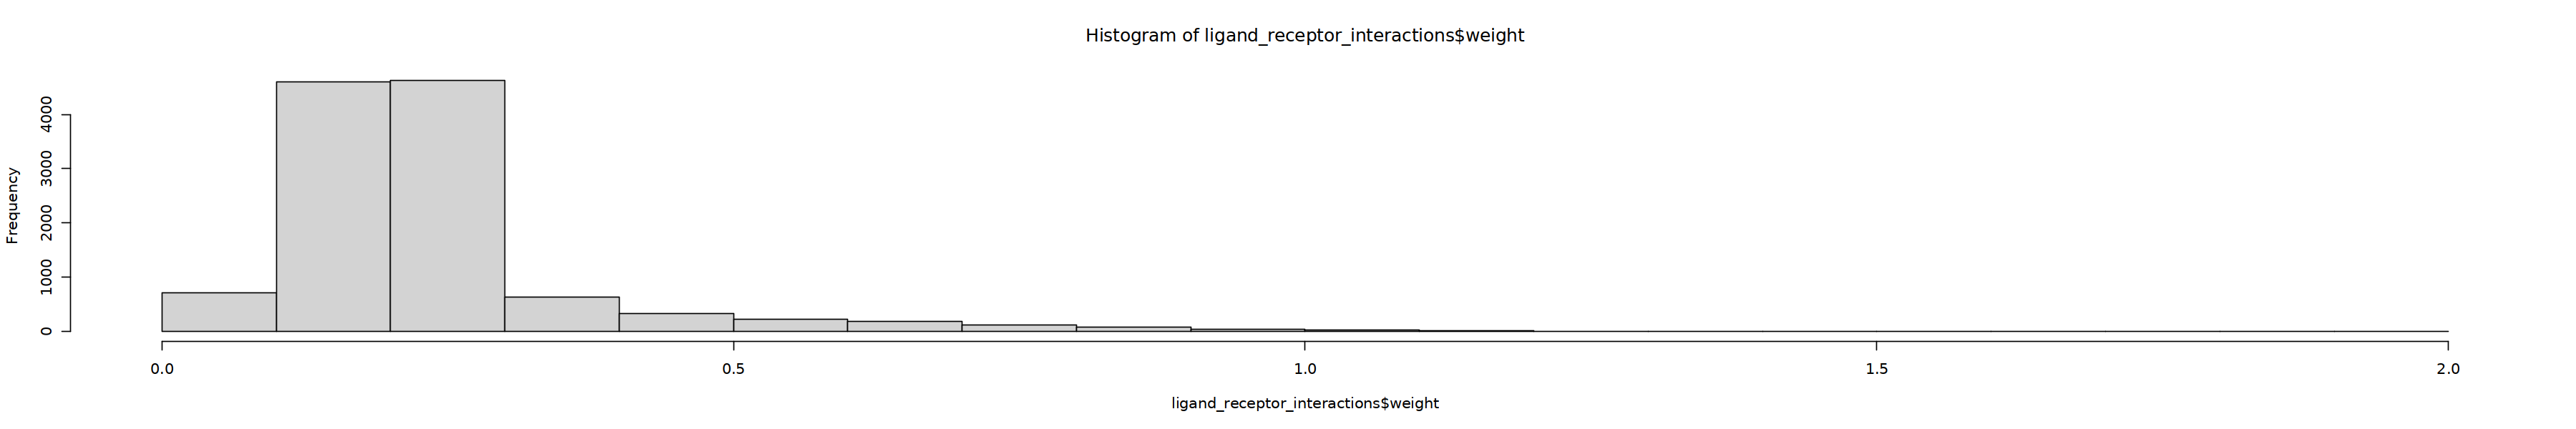

In [477]:
hist(ligand_receptor_interactions$weight)

In [478]:
#### Add expression data of ligands and receptors

In [479]:
unique(analyze_expr_cluster$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

In [480]:
head(analyze_expr_cluster,2)

,interaction_type,gene,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,mean_expr,var_expression,cell_type,cluster_vis
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>
1,Ligand,A2M,proteomics,proteomics,69.10381,NA,proteomics_0_A2M_P01023,8.7445302,0.32468578,proteomics,NA
2,Ligand,ADAM17,single_cell,X4_Monocytes...CD14,49.68889,7267,single_cell_0_X4_Monocytes...CD14__ADAM17,0.8383966,0.03136488,Monocytes...CD14,3


In [481]:
analyze_expr_cluster$variable = paste0(analyze_expr_cluster$cluster, '_0_', analyze_expr_cluster$gene)

In [482]:
nrow(ligand_receptor_interactions)

[1] 11639

In [483]:
#### Add data for ligands
data  = merge(ligand_receptor_interactions, analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Ligand',], by.x = c('Ligand'), by.y = c('gene'),  suffixes = c("","_L"))

In [484]:
#### Add data for Receptors
data  = merge(data, analyze_expr_cluster[analyze_expr_cluster$interaction_type == 'Receptor',], by.x = c('Receptor'), by.y = c('gene'),  suffixes = c("","_R"))

In [485]:
head(data,2)

,Receptor,Ligand,amount_sources,weight,interaction_type,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,⋯,type_R,cluster_R,perc_cells_expressing_gene_R,total_amount_cells_expressing_gene_R,ident_R,mean_expr_R,var_expression_R,cell_type_R,cluster_vis_R,variable_R
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ABCA7,APOA1,1,0.4572367,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_APOA1_P02647,⋯,neutrophil,neutrophil,69.10381,NA,neutrophil_0_ABCA7,1.387586,0.8848451,neutrophil,NA,neutrophil_0_ABCA7
2,ADIPOR1,ADIPOQ,1,0.7307022,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_ADIPOQ_Q15848,⋯,neutrophil,neutrophil,69.10381,NA,neutrophil_0_ADIPOR1,2.269589,0.8178776,neutrophil,NA,neutrophil_0_ADIPOR1


In [486]:
colnames(data)

[1] "Receptor"                            
 [2] "Ligand"                              
 [3] "amount_sources"                      
 [4] "weight"                              
 [5] "interaction_type"                    
 [6] "type"                                
 [7] "cluster"                             
 [8] "perc_cells_expressing_gene"          
 [9] "total_amount_cells_expressing_gene"  
[10] "ident"                               
[11] "mean_expr"                           
[12] "var_expression"                      
[13] "cell_type"                           
[14] "cluster_vis"                         
[15] "variable"                            
[16] "interaction_type_R"                  
[17] "type_R"                              
[18] "cluster_R"                           
[19] "perc_cells_expressing_gene_R"        
[20] "total_amount_cells_expressing_gene_R"
[21] "ident_R"                             
[22] "mean_expr_R"                         
[23] "var_expression_R"                    
[24] "cell_type_R"                         
[25] "cluster_vis_R"                       
[26] "variable_R"

In [487]:
nrow(data)

[1] 5835

In [488]:
unique(data$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

In [489]:
#### Remove same type links (ligands to receptors of same type)

In [490]:
data = data[data$cell_type != data$cell_type_R,]

In [491]:
nrow(data)

[1] 4930

In [492]:
unique(data$type)

[1] "proteomics"  "single_cell" "neutrophil"  "cytokine"

## Combine expression data and interaction potential with correlations

In [493]:
head(ligand_receptor_correlations,2)

,ligand,receptor,correlation
,<fct>,<fct>,<dbl>
1,cytokine_0_BCA1__CXCL13,neutrophil_0_ABCA7,0.09543501
2,cytokine_0_CTACK__CCL27,neutrophil_0_ABCA7,0.05916357


In [494]:
head(data,2)

,Receptor,Ligand,amount_sources,weight,interaction_type,type,cluster,perc_cells_expressing_gene,total_amount_cells_expressing_gene,ident,⋯,type_R,cluster_R,perc_cells_expressing_gene_R,total_amount_cells_expressing_gene_R,ident_R,mean_expr_R,var_expression_R,cell_type_R,cluster_vis_R,variable_R
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ABCA7,APOA1,1,0.4572367,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_APOA1_P02647,⋯,neutrophil,neutrophil,69.10381,NA,neutrophil_0_ABCA7,1.387586,0.8848451,neutrophil,NA,neutrophil_0_ABCA7
2,ADIPOR1,ADIPOQ,1,0.7307022,Ligand,proteomics,proteomics,69.10381,NA,proteomics_0_ADIPOQ_Q15848,⋯,neutrophil,neutrophil,69.10381,NA,neutrophil_0_ADIPOR1,2.269589,0.8178776,neutrophil,NA,neutrophil_0_ADIPOR1


In [495]:
nrow(data)

[1] 4930

In [496]:
nrow(ligand_receptor_correlations)

[1] 163315

In [497]:
data = merge(data, ligand_receptor_correlations, by.x = c('ident', 'ident_R'), by.y = c('ligand', 'receptor'))

In [498]:
nrow(data)

[1] 4930

In [499]:
filter_samples

[1] "all"

In [500]:
## save the data

In [501]:
write.table(data,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data', name, filter_samples,'.gz')))

## Define expressed ligands and potential ligand - target combinations based on expressed receptors

In [502]:
### Define minimum amount of expression of receptor in receiving cell to be able to react to ligand

In [503]:
head(ligand_receptor_interactions,2) # all potential ligand receptor interactions

,Ligand,Receptor,amount_sources,weight
,<chr>,<chr>,<int>,<dbl>
1,A2M,LRP1,1,0.4678977
2,A2M,TNFRSF14,1,0.6990671


In [504]:
head(cell_perc_cluster,2)   # expression of the genes in cells

,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<chr>,<dbl>,<int>,<chr>,<chr>
1,AL627309.1,0.24327612,18,AL627309.1,X8_B.cell
2,AL627309.4,0.05406136,4,AL627309.4,X8_B.cell


In [505]:
### Set threshold to filter out receptors that are to low expressed
cell_perc_cluster_filtered =  cell_perc_cluster[((cell_perc_cluster$perc_cells > 30) & (cell_perc_cluster$total_amount_cells_expressing_gene > 600)) | ((cell_perc_cluster$perc_cells > 10) & (cell_perc_cluster$total_amount_cells_expressing_gene > 1200)),]

In [506]:
### Define all potential ligand receptor interactions based on expression
potential_ligand_target_types_comb = merge(ligand_receptor_interactions, cell_perc_cluster_filtered, by.x = 'Receptor', by.y = 'gene')

In [507]:
head(potential_ligand_target_types_comb,2)

,Receptor,Ligand,amount_sources,weight,X,perc_cells_expressing_gene,total_amount_cells_expressing_gene,cluster
,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>,<int>,<chr>
1,ABCA1,APOA1,1,0.8194814,ABCA19,15.74701,2303,X4_Monocytes...CD14
2,ABCA1,APOA1,1,0.8194814,ABCA17,16.46135,1844,X6_Monocytes...CD14


In [508]:
### Define potential ligand interactions with target cell-types (minimum one receptor that can interact with the ligand on the cell-type)
potential_ligand_target_types_comb = unique(potential_ligand_target_types_comb[,c('Ligand', 'cluster')] )

In [509]:
colnames(potential_ligand_target_types_comb) = c('Ligand', 'cluster_R')

In [510]:
head(potential_ligand_target_types_comb,2) # ligands and the cluster-cell types they can affect

,Ligand,cluster_R
,<chr>,<chr>
1,APOA1,X4_Monocytes...CD14
2,APOA1,X6_Monocytes...CD14


In [511]:
unique(potential_ligand_target_types_comb$cluster_R)

[1] "X4_Monocytes...CD14"         "X6_Monocytes...CD14"        
 [3] "X2_T.cell.CD4"               "X1_T.cell.CD8"              
 [5] "X7_Monocytes...CD14"         "X0_T.cell.CD4"              
 [7] "X12_Monocytes...CD16_FCGR3A" "X3_NK"                      
 [9] "X9_Monocytes...CD16_FCGR3A"  "X8_B.cell"                  
[11] "X11_T.cell.CD4"              "X10_B.cell"                 
[13] "X5_T.cell.CD4"               "X13_Dendritic"

In [512]:
# Below: ligands where receptors are only expressed in very low amount of targets  (removed ligands)
unique(potential_ligand_target_types_comb[,c('Ligand', 'cluster_R')]) %>% group_by(Ligand) %>% count() %>% filter(n == 1)


Ligand,n
<chr>,<int>
ARTN,1
CNTN2,1
DEFB4A,1
DEFB4B,1
DHH,1
FLT3LG,1
GPHA2,1
IHH,1
IL18,1


In [513]:
## get all expressed ligands per cluster

In [514]:
expressed_ligand_types = unique(data[,c('Ligand', 'cluster', 'mean_expr', 'type', 'variable', 'ident')])

# Ligand Target Data

## Calculate ligand - target correlations

In [515]:
### expressed ligands per cluster
head(expressed_ligand_types,2)

,Ligand,cluster,mean_expr,type,variable,ident
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,CXCL13,cytokine,5.429313,cytokine,cytokine_0_CXCL13,cytokine_0_BCA1__CXCL13
30,CCL27,cytokine,9.723839,cytokine,cytokine_0_CCL27,cytokine_0_CTACK__CCL27


In [516]:
#### Determine expressed ligands in single-cell data
expressed_ligand_types$variable[expressed_ligand_types$type == 'single_cell'] = paste0(expressed_ligand_types$type[expressed_ligand_types$type == 'single_cell'], '_0_',expressed_ligand_types$cluster[expressed_ligand_types$type == 'single_cell'], '__', expressed_ligand_types$Ligand[expressed_ligand_types$type == 'single_cell'] )

In [517]:
expressed_ligands = unique(expressed_ligand_types$ident)

In [518]:
length(expressed_ligands)

[1] 344

In [519]:
### Transform data_long to matrix format

In [520]:
head(data_long,2)

,type,variable,X,sample_id,value,config,expression,ident,gene
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,clinical_data,CK,1557210,k1,5.459432,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK
2,clinical_data,CK,1557211,k10,NA,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-,TRUE,clinical_data_0_CK,CK


In [521]:
expression_data = data_long %>% dcast(sample_id ~ ident, value.var = 'value')

In [522]:
rownames(expression_data) = expression_data$sample_id

In [523]:
expression_data$sample_id = NULL

In [524]:
head(expression_data,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k1,5.459432,NA,0.4854268,NA,0.01863417,5.696550,9.821662,5.045268,10.562366,7.42341,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,NA,NA,0.2630344,NA,NA,4.697663,9.701220,1.922198,7.724173,9.19842,⋯,2.461054,2.157169,1.975326,3.139595,2.078417,1.843355,1.343136,0.6540153,1.190677,0.8572279


In [525]:
### Calculate all correlations between ligands and targets

In [526]:
ligand_target_correlations = cor(expression_data[,colnames(expression_data) %in% expressed_ligands], expression_data[,!colnames(expression_data) %in% expressed_ligands], method = 'spearman', use = 'pairwise.complete.obs') 

Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”
Warn

In [527]:
head(ligand_target_correlations,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_delta_ef_value,clinical_data_0_Troponin,cytokine_0_Eotaxin__CCL11,cytokine_0_Eotaxin2__CCL24,cytokine_0_FLT3L__FLT3LG,cytokine_0_GROalpha__CXCL1,cytokine_0_IL12p40__IL12B,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
cytokine_0_BCA1__CXCL13,0.04568048,0.1841583,0.03474096,-0.263390374,0.08664079,-0.4042097,0.07479910,-0.12506712,-0.20342629,-0.06320019,⋯,0.14780538,0.06469496,-0.033172594,0.02807027,0.006225096,0.08782851,-0.06057393,0.1023231,0.20825309,-0.02657856
cytokine_0_CTACK__CCL27,-0.19761446,-0.3175698,0.01813627,-0.008483006,-0.09251747,0.1002265,0.07672164,-0.02487356,-0.03717696,0.30506995,⋯,-0.02130075,-0.15482846,0.004267636,-0.11350619,-0.029636124,-0.04159127,0.08755046,-0.1470658,-0.01133356,-0.05600466


In [528]:
### Transform to long format

In [529]:
ligand_target_correlations = melt(ligand_target_correlations)

In [530]:
colnames(ligand_target_correlations) = c('Ligand', 'Target', 'correlation')

In [531]:
### Adjust format and extract certain columns

In [532]:
ligand_target_correlations$Target_Gene = str_replace(ligand_target_correlations$Target, '.*_0_', '')

In [533]:
ligand_target_correlations$Target_Gene = str_replace(ligand_target_correlations$Target_Gene, '.*__', '')

In [534]:
ligand_target_correlations$Ligand_Gene = str_replace(ligand_target_correlations$Ligand, '.*_0_', '')

In [535]:
ligand_target_correlations$Ligand_Gene = str_replace(ligand_target_correlations$Ligand_Gene, '.*__', '')

In [536]:
ligand_target_correlations$Target_Type = str_replace(ligand_target_correlations$Target, '_0_.*', '')

In [537]:
ligand_target_correlations$Target_Type[ligand_target_correlations$Target_Type == 'single_cell']  = str_replace(ligand_target_correlations$Target[ligand_target_correlations$Target_Type == 'single_cell'] , '__.*', '')

In [538]:
###  Adapt target gene format for proteomics
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target_Type == 'proteomics'] = str_replace(ligand_target_correlations$Target_Gene[ligand_target_correlations$Target_Type == 'proteomics'], '_.*', '')
ligand_target_correlations$Ligand_Gene[ligand_target_correlations$Ligand_Type == 'proteomics'] = str_replace(ligand_target_correlations$Ligand_Gene[ligand_target_correlations$Ligand_Type == 'proteomics'], '_.*', '')

In [539]:
ligand_target_correlations$Ligand_Type = str_replace(ligand_target_correlations$Ligand, '_0_.*', '')

In [540]:
ligand_target_correlations$Ligand_Type[ligand_target_correlations$Ligand_Type == 'single_cell']  = str_replace(ligand_target_correlations$Ligand[ligand_target_correlations$Ligand_Type == 'single_cell'] , '__.*', '')

In [541]:
head(sort(unique(ligand_target_correlations$Ligand)))

[1] cytokine_0_BCA1__CXCL13    cytokine_0_CTACK__CCL27   
[3] cytokine_0_EGF__EGF        cytokine_0_ENA78__CXCL5   
[5] cytokine_0_Eotaxin3__CCL26 cytokine_0_FGF2__FGF2     
344 Levels: cytokine_0_BCA1__CXCL13 ... single_cell_0_X9_Monocytes...CD16_FCGR3A__TNFSF13B

In [542]:
unique(ligand_target_correlations$Target_Type)

[1] "clinical_data"                            
 [2] "cytokine"                                 
 [3] "neutrophil"                               
 [4] "proteomics"                               
 [5] "single_cell_0_X0_T.cell.CD4"              
 [6] "single_cell_0_X1_T.cell.CD8"              
 [7] "single_cell_0_X10_B.cell"                 
 [8] "single_cell_0_X11_T.cell.CD4"             
 [9] "single_cell_0_X12_Monocytes...CD16_FCGR3A"
[10] "single_cell_0_X13_Dendritic"              
[11] "single_cell_0_X2_T.cell.CD4"              
[12] "single_cell_0_X3_NK"                      
[13] "single_cell_0_X4_Monocytes...CD14"        
[14] "single_cell_0_X5_T.cell.CD4"              
[15] "single_cell_0_X6_Monocytes...CD14"        
[16] "single_cell_0_X7_Monocytes...CD14"        
[17] "single_cell_0_X8_B.cell"                  
[18] "single_cell_0_X9_Monocytes...CD16_FCGR3A"

In [543]:
ligand_target_correlations$cluster = str_replace(ligand_target_correlations$Target_Type, 'single_cell_0_', '')

In [544]:
unique(ligand_target_correlations$cluster)

[1] "clinical_data"               "cytokine"                   
 [3] "neutrophil"                  "proteomics"                 
 [5] "X0_T.cell.CD4"               "X1_T.cell.CD8"              
 [7] "X10_B.cell"                  "X11_T.cell.CD4"             
 [9] "X12_Monocytes...CD16_FCGR3A" "X13_Dendritic"              
[11] "X2_T.cell.CD4"               "X3_NK"                      
[13] "X4_Monocytes...CD14"         "X5_T.cell.CD4"              
[15] "X6_Monocytes...CD14"         "X7_Monocytes...CD14"        
[17] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A"

In [545]:
head(ligand_target_correlations,2)

,Ligand,Target,correlation,Target_Gene,Ligand_Gene,Target_Type,Ligand_Type,cluster
,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cytokine_0_BCA1__CXCL13,clinical_data_0_CK,0.04568048,CK,CXCL13,clinical_data,cytokine,clinical_data
2,cytokine_0_CTACK__CCL27,clinical_data_0_CK,-0.19761446,CK,CCL27,clinical_data,cytokine,clinical_data


## Filter on ligands with matching receptor in target

In [546]:
head(potential_ligand_target_types_comb,2) # dataset with available receptor for ligands in target types

,Ligand,cluster_R
,<chr>,<chr>
1,APOA1,X4_Monocytes...CD14
2,APOA1,X6_Monocytes...CD14


In [547]:
nrow(ligand_target_correlations)

[1] 4451016

In [548]:
filter_matched_receptor = TRUE  # filter out ligands for which there is a receptor in the target type if true

In [549]:
if(filter_matched_receptor == TRUE){
    ### seperately add clinical, proteomics as target (as here no filtering based on expression is applied)
    no_sc = ligand_target_correlations[ligand_target_correlations$Target_Type %in%  c('clinical_data', 'proteomics', 'neutrophil'),]
    ### filter the ligands
    ligand_target_correlations = merge(ligand_target_correlations, potential_ligand_target_types_comb[,c('Ligand', 'cluster_R')], by.x = c('Ligand_Gene', 'cluster'), by.y = c('Ligand', 'cluster_R'))
    
    ### add other omics data
    ligand_target_correlations = rbind(ligand_target_correlations, no_sc)
    
}

In [550]:
nrow(ligand_target_correlations)

[1] 3522537

## Add regulatory potential

In [551]:
## add ligand target regulatory potential score from nichenet to the data

In [552]:
head(ligand_target_matrix_long,2) # regulatory potential scores from nichenet

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [553]:
### Adjust target gene names for clinical data (to be included later on)
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_CK'] = 'CKM'
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_CK_MB'] = 'CKB'
ligand_target_correlations$Target_Gene[ligand_target_correlations$Target == 'clinical_data_0_Troponin'] = 'TNNT2'

In [554]:
### Merge regulatory potential scores

In [555]:
ligand_target_correlations = merge(ligand_target_correlations, ligand_target_matrix_long, by.x = c('Ligand_Gene', 'Target_Gene'), by.y = c('ligand', 'target'))

In [556]:
nrow(ligand_target_correlations)

[1] 3314320

In [557]:
## scale the regulatory potential score based on max value

In [558]:
ligand_target_correlations$regulatory_potential_scaled = ligand_target_correlations$regulatory_potential/ max(ligand_target_correlations$regulatory_potential)

## Adjustments to ligand-target correlations

In [559]:
### Remove cytokines that have been calculated as targets (because not included in ligand list above)

In [560]:
nrow(ligand_target_correlations)

[1] 3314320

In [561]:
ligand_target_correlations = ligand_target_correlations[ligand_target_correlations$Target_Type != 'cytokine',]

In [562]:
nrow(ligand_target_correlations)

[1] 3314320

In [563]:
### Only look at between cell-type communications --> remove same cell-type Links

In [564]:
ligand_target_correlations$Target_Cell_Type = str_replace(ligand_target_correlations$Target_Type, '.*_X\\d_|.*_X\\d\\d_','')

In [565]:
ligand_target_correlations$Ligand_Cell_Type = str_replace(ligand_target_correlations$Ligand_Type, '.*_X\\d_|.*_X\\d\\d_','')

In [566]:
ligand_target_correlations = ligand_target_correlations[ligand_target_correlations$Target_Cell_Type != ligand_target_correlations$Ligand_Cell_Type,]

In [567]:
nrow(ligand_target_correlations)

[1] 2721225

## Save the ligand target data

In [568]:
name

[1] "V_FINAL"

In [569]:
write.table(ligand_target_correlations,gzfile(paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Target_Data', name, filter_samples,'.gz')))